# SCOREO / SIMULACION

## *Librerías y configuraciones de la notebook*foco_muestra

In [1]:
a = 'hola'
b= 'chau'
print('{} me llamo Santi. {}'.format(a,b))

hola me llamo Santi. chau


In [2]:
2 <= 2

True

In [6]:
def multiply(a, b, bound):
    # write your code here
    result = a * b
    if result > bound:
        raise ValueError('multiplication of {} and {} with bound {} not possible'.format(a,b,bound))
    else:
        return result

In [12]:
multiply(2,6,8)

ValueError: multiplication of 2 and 6 with bound 8 not possible

In [27]:
##### Librerías y modulos #######
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
import openpyxl
import random
import os,json

In [2]:
####### Configuraciones de la notebook (a gusto del usuario) ##########
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# warnings
warnings.filterwarnings("ignore")

In [54]:
#### Parametros de la notebook ####
path_save = '../datos/'
path_model = '../model/'

In [3]:
####### requierments ###########
#!pip install pandas-gbq

In [4]:
# Importar tabla OOT de Big Query
df_scoreo_oot = gbq.read_gbq("SELECT * FROM `data-team-k.pricing_data.match_meli_ok` WHERE date > '2022-02-15' ", project_id="data-team-k")

In [5]:
# chequeo
print(len(df_scoreo_oot))
print(df_scoreo_oot.date.min(), df_scoreo_oot.date.max())

640030
2022-02-16 00:00:00 2022-02-22 00:00:00


## *Seteo de parametros de la notebook*

In [7]:
# Semilla para el .sample()
seed = random.randint(10,500)
foco_muestra = "alta_presencia"  # "alta_presencia" , "baja_presencia" o "sin_foco"
if foco_muestra not in ["alta_presencia" , "baja_presencia", "sin_foco"]:
    raise ValueError('Revisar el valor que le pasamos al parametro "foco_muestra", las opciones disponibles son: "alta_presencia", "baja_presencia" o "sin_foco"')
print(f'Parametros de la simulación: seed:{seed}, foco_muestra: {foco_muestra}')

Parametros de la simulación: seed:495, foco_muestra: alta_presencia


## 1) Pre procesing

**Removing duplicates**

In [8]:
# Tratamiento de la feautre "runtime"
df_scoreo_oot['runtime'] = pd.to_datetime(df_scoreo_oot.runtime.apply(lambda x: str(x)[:19]))
df_scoreo_oot = df_scoreo_oot.sort_values(['runtime'])
# Ahora si, teniendo el df ordenado, eliminamos los duplicados, quedandonos con el registro más reciente (la última ocurrencia)
df_scoreo_oot.drop_duplicates(subset=['car_id'], keep='last', inplace=True)

In [9]:
df_scoreo_oot.shape

(103074, 42)

**Dropeo de casos extraños como 11111 o 999999**

In [1]:
# traerlo de la notebook de train

**Final Price (target)** <br>

In [10]:
# Construcción del precio final
blue= 215
oficial= 112.97
col1 = 'price_symbol'
col2 = 'car_kms'
conditions = [df_scoreo_oot[col1]!='U$S', (df_scoreo_oot[col1]=='U$S') & (df_scoreo_oot[col2]==0), (df_scoreo_oot[col1]=='U$S') & (df_scoreo_oot[col2]!=0)]
choices = [df_scoreo_oot.price_amount, df_scoreo_oot['price_amount']*oficial, df_scoreo_oot['price_amount']*blue]

df_scoreo_oot['price_meli_ok'] = np.select(conditions, choices, default=np.nan)

**Removing 0kms y concesionarias** <br>

In [11]:
df_scoreo_oot['dealer'] = np.where(df_scoreo_oot['dealer']==True,1,0)
mask_not_0km = df_scoreo_oot.car_kms > 90
mask_not_conces = df_scoreo_oot.dealer == 0

df_scoreo_oot = df_scoreo_oot[(mask_not_0km) & (mask_not_conces)]

In [12]:
df_scoreo_oot.shape

(40551, 43)

**Removing low matching scores** <br>

In [13]:
lst = ['score_marca_a','score_modelo_a','score_v1_c']
for col in lst:
    df_scoreo_oot = df_scoreo_oot[df_scoreo_oot[col]>=50]
    
# chequeo
df_scoreo_oot[lst].min()

score_marca_a    92.0000
score_modelo_a   50.0000
score_v1_c       50.0000
dtype: float64

In [14]:
df_scoreo_oot.shape

(37745, 43)

**Removing categories** <br>

In [17]:
cats_loc1_ok = ['Capital Federal','Bs.As. G.B.A. Sur','Bs.As. G.B.A. Norte'
           ,'Bs.As. G.B.A. Oeste','Buenos Aires Interior','Bs.As. Costa Atlántica']
mask1 = df_scoreo_oot.car_location_1.apply(lambda x: x in cats_loc1_ok)
cats_brand_ok =['Alfa Romeo','Audi','BMW','Chery','Chevrolet','Citroën','DS','Fiat','Ford','Geely','Haval','Honda',
 'Hyundai','JAC','Jeep','Kia','Land Rover','Lifan','Mercedes-Benz','Mini','Mitsubishi','Nissan','Peugeot','Porsche','RAM',
 'Renault','SEAT','Shineray','Smart','Subaru','Suzuki','Toyota','Volkswagen','Volvo'] # Exclusion x pedido Edgar: Dodge, Chrysler
mask2 = df_scoreo_oot.brand.apply(lambda x: x in cats_brand_ok)
sub_mask = df_scoreo_oot.brand == 'Jeep'
lst_not_renegade = [i for i in df_scoreo_oot[sub_mask]['match_modelo_a'].unique() if i != 'Renegade']
mask3 = df_scoreo_oot.match_modelo_a.apply(lambda x: x not in lst_not_renegade)
df_scoreo_oot = df_scoreo_oot[(mask1 & mask2 & mask3)]

In [18]:
df_scoreo_oot.shape

(25981, 43)

**Make sure we are only taking into consideration last 15 days** <br>

In [19]:
df_scoreo_oot.runtime.max()

Timestamp('2022-02-22 23:01:32')

In [20]:
from datetime import date, datetime, timedelta
# df.runtime.max() - timedelta(days=15) 

In [21]:
max_date = df_scoreo_oot.runtime.max()
mask_last15d = (df_scoreo_oot.runtime <= max_date) & ((df_scoreo_oot.runtime >= max_date - timedelta(days=15)))
df_scoreo_oot = df_scoreo_oot[mask_last15d]

In [22]:
print(df_scoreo_oot.runtime.min())
print(df_scoreo_oot.runtime.max())

2022-02-16 00:00:21
2022-02-22 23:01:32


In [24]:
df_scoreo_oot.shape

(25981, 43)

**Rmeoving outliers** <br>

In [33]:
# Levantamos los valores para el capeo de outliers aprendidos del dataset de train
with open('{}thres_outl.txt'.format(path_save)) as f:
    dic_outl_thres = json.load(f)
    print(dic_outl_thres)

{'q_99_p': 11394836.6, 'q_005_p': 540000.0, 'q_99_km': 310000.0, 'q_005_km': 1000.0}


In [34]:
df_scoreo_oot = df_scoreo_oot[(df_scoreo_oot.price_meli_ok <= dic_outl_thres['q_99_p']) & (df_scoreo_oot.car_kms <= dic_outl_thres['q_99_km'])]
print(df_scoreo_oot.shape)

(25476, 43)


In [35]:
# chequeamos distribucion del target
df_scoreo_oot.price_meli_ok.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])

count      25476.0000
mean     2466302.0098
std      1743292.5750
min       115000.0000
0.1%      464750.0000
1%        628750.0000
10%       900000.0000
25%      1300000.0000
50%      1930000.0000
75%      3010000.0000
90%      4730000.0000
99%      9212700.0000
max     11394785.0000
Name: price_meli_ok, dtype: float64

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

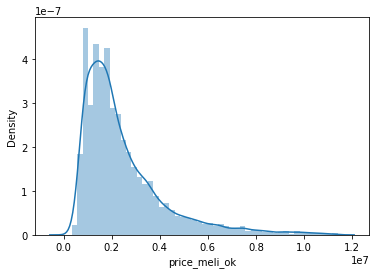

In [36]:
# chequeamos distribucion del target
sns.distplot(df_scoreo_oot.price_meli_ok)

## 2) Final Dataset to score

In [44]:
id_features = ['runtime','car_id']
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_c', 'Subseg_a', 'Seg_a']
others = ['car_location_1', 'match_v1_a']
target = ['price_meli_ok']

In [45]:
# Dataset final
df_oot_final = df_scoreo_oot[id_features + model_features + others + target].copy()

In [46]:
# nulls
df_oot_final.isnull().sum()

runtime           0
car_id            0
car_year          0
car_kms           0
match_marca_a     0
match_modelo_a    0
match_v1_c        0
Subseg_a          0
Seg_a             0
car_location_1    0
match_v1_a        0
price_meli_ok     0
dtype: int64

In [47]:
# Eliminamos los registros con nulos
# for col in final_features:
#     df_scoreo_oot_final = df_scoreo_oot_final[~df_scoreo_oot_final[col].isnull()]

In [48]:
df_oot_final.shape

(25476, 12)

**Foco de la muestra**

En este step lo que sucede es que filtramos la muestra para quedarnos con un grupo selecto en base a la presencia en MELI. Ejemplo: si seteamos foco_muestra = 'alta_presencia', nuestro dataset va a quedar compuesto únicamente de los modelos con más presencia en la plataforma.

In [49]:
if foco_muestra == 'alta_presencia':
    df_grouped = df_oot_final.groupby(['match_marca_a','match_modelo_a'], as_index=False).size()
    df_grouped= df_grouped.sort_values(by='size', ascending=False).iloc[:15,:]  # los primeros 15 registros
    marca_cats = list(df_grouped.match_marca_a.unique())
    modelo_cats = list(df_grouped.match_modelo_a.unique())
    mask1 = df_oot_final.match_marca_a.apply(lambda x: x in marca_cats)
    mask2 = df_oot_final.match_modelo_a.apply(lambda x: x in modelo_cats)
    df_oot_final = df_oot_final[(mask1 & mask2)]
elif foco_muestra == 'baja_presencia':
    df_grouped = df_oot_final.groupby(['match_marca_a'], as_index=False).size()
    df_grouped= df_grouped.sort_values(by='size', ascending=False).iloc[-15:,:]  # los ultimos 15 registros
    marca_cats = list(df_grouped.match_marca_a.unique())
    mask = df_oot_final.match_marca_a.apply(lambda x: x in marca_cats)
    df_oot_final = df_oot_final[mask]
elif foco_muestra == 'sin_foco':
    pass
else:
    raise ValueError('Revisar el valor que le pasamos al parametro "foco_muestra", las opciones disponibles son "alta_presencia", "baja_presencia" o "sin_foco"')

In [51]:
df_oot_final.shape

(8860, 12)

## 3) Seleccion muestra final (50 casos)

In [52]:
# Seleccion final de la muestra de 50 registros
df_oot_final_sample = df_oot_final.sample(n=50, random_state=seed) 
df_oot_final_sample

,runtime,car_id,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_c,Subseg_a,Seg_a,car_location_1,match_v1_a,price_meli_ok
419607,2022-02-21 23:00:27,1117117560,2010,176000.0000,VOLKSWAGEN,Gol Trend,1.6,Gama Pequenos Hatchback,Gama Pequenos,Bs.As. G.B.A. Sur,1.6 3Ptas. Trendline / Pack I (101cv),1150000.0000
246236,2022-02-22 04:01:10,1117466525,2017,30000.0000,FORD,Fiesta,1.6L TITANIUM POWERSHIFT,Gama Pequenos Hatchback,Gama Pequenos,Bs.As. G.B.A. Sur,Max 4Ptas. 1.6 N Ambiente Plus,2902500.0000
236290,2022-02-22 15:00:52,1118013858,2011,93000.0000,VOLKSWAGEN,Vento,2.0,Gama Medianos Sedan,Gama Medianos,Bs.As. G.B.A. Oeste,2.0 TFSI Sportline MT (200cv),2902500.0000
206896,2022-02-22 03:00:29,1122454986,2019,26000.0000,PEUGEOT,308,1.6,Gama Pequenos Hatchback,Gama Pequenos,Buenos Aires Interior,S 1.6 THP 8AT GT (225cv) 5Ptas.,6450000.0000
39334,2022-02-19 10:01:31,1124023248,2016,72000.0000,VOLKSWAGEN,Suran,1.6L 5D I-MOTION 1250/21C,Monovolumen Compacto,Monovolumen,Bs.As. G.B.A. Norte,1.6 MSI Comfortline (L18),1780000.0000
247308,2022-02-22 08:00:26,1123024549,2015,174000.0000,RENAULT,Kangoo,CONFORT 1.6,Baja PU - Furgones,Livianos,Capital Federal,PH3 1.6 Authentique 1PLC,1550000.0000
157052,2022-02-18 04:00:25,1123115635,2015,48000.0000,PEUGEOT,208,ACTIVE 1.5 N,Gama Pequenos Hatchback,Gama Pequenos,Bs.As. G.B.A. Sur,1.5 N 8v Active (90cv),1750000.0000
241771,2022-02-22 15:00:33,1117990881,2017,138000.0000,VOLKSWAGEN,Amarok,DC 2.0L TDI 180CV HIGHLINE 4X2 AUT EU5,Pickups Medianas-Grandes,Livianos,Buenos Aires Interior,2.0 TDI (180cv) 4x2 C/Doble Highline Pack AT,5600000.0000
230371,2022-02-22 14:00:34,1120185155,2016,217400.0000,TOYOTA,Hilux,4X4,Pickups Medianas-Grandes,Livianos,Buenos Aires Interior,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),5900000.0000
453297,2022-02-22 19:01:17,1124384908,2015,120000.0000,VOLKSWAGEN,Gol Trend,1.6,Gama Pequenos Hatchback,Gama Pequenos,Bs.As. G.B.A. Norte,1.6 MSI 5Ptas. Highline (101cv) (L17),1450000.0000


In [53]:
# nos quedamos solo con las features que usamos en el entrenamiento del modelo para hacer el predict del modelo
X_oot = df_oot_final_sample[model_features].copy()

## 4) Scoreo de la muestra final

In [56]:
# Paso 1: Levantamos el modelo ya entrenado en la notebook anterior
import pickle
with open('{}model_catboost_v2.pickle'.format(path_model), 'rb') as f:
    model = pickle.load(f)

In [57]:
# Paso 2: predict sobre la data nueva
pred = model.predict(X_oot)

In [58]:
type(pred)

numpy.ndarray

In [59]:
len(pred)

50

## 5) Armado del output final

In [60]:
# Precio promedio en MELI
if foco_muestra in ['alta_presencia','sin_foco']:
    grouped = df_oot_final.groupby(['match_marca_a','match_modelo_a','match_v1_a','car_year'], as_index=False)['price_meli_ok'].mean()
    grouped.rename(columns={'price_meli_ok':'precio_prom_meli'},inplace=True)
    df_oot_final_sample = df_oot_final_sample.merge(grouped, how='inner'
                                                                  , on=['match_marca_a','match_modelo_a','match_v1_a','car_year'])
elif foco_muestra == 'baja_presencia':  # si el foco es baja_presencia, la agrupación la hacemos de menos niveles
    grouped = df_oot_final.groupby(['match_marca_a','match_modelo_a','car_year'], as_index=False)['price_meli_ok'].mean()
    grouped.rename(columns={'price_meli_ok':'precio_prom_meli'},inplace=True)
    df_oot_final_sample = df_oot_final_sample.merge(grouped, how='inner'
                                                                  , on=['match_marca_a','match_modelo_a','car_year'])
else:
    raise ValueError('Revisar el valor que le pasamos al parametro "foco_muestra", las opciones disponibles son: "alta_presencia", "baja_presencia" o "sin_foco"')

In [61]:
df_oot_final_sample['precio_estimado'] = pred

In [62]:
df_oot_final_sample['precio_estimado'] = df_oot_final_sample['precio_estimado'].astype('int64')

In [63]:
from datetime import datetime
df_oot_final_sample['fecha_simulacion'] = datetime.today().strftime('%Y-%m-%d')

In [64]:
df_oot_final_sample.columns

Index(['runtime', 'car_id', 'car_year', 'car_kms', 'match_marca_a',
       'match_modelo_a', 'match_v1_c', 'Subseg_a', 'Seg_a', 'car_location_1',
       'match_v1_a', 'price_meli_ok', 'precio_prom_meli', 'precio_estimado',
       'fecha_simulacion'],
      dtype='object')

In [65]:
# Ordenamos las columnas de forma prolija
df_oot_final_sample = df_oot_final_sample[['car_id','match_marca_a','match_modelo_a','match_v1_a','match_v1_c'
                                                         ,'car_year','car_kms','Seg_a','Subseg_a','car_location_1'
                                                         ,'precio_estimado','precio_prom_meli','fecha_simulacion']]

In [66]:
# chequeo
df_oot_final_sample.head()

,car_id,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,car_year,car_kms,Seg_a,Subseg_a,car_location_1,precio_estimado,precio_prom_meli,fecha_simulacion
0,1117117560,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),1.6,2010,176000.0000,Gama Pequenos,Gama Pequenos Hatchback,Bs.As. G.B.A. Sur,987097,1101818.1818,2022-02-23
1,1117466525,FORD,Fiesta,Max 4Ptas. 1.6 N Ambiente Plus,1.6L TITANIUM POWERSHIFT,2017,30000.0000,Gama Pequenos,Gama Pequenos Hatchback,Bs.As. G.B.A. Sur,2378350,2902500.0000,2022-02-23
2,1118013858,VOLKSWAGEN,Vento,2.0 TFSI Sportline MT (200cv),2.0,2011,93000.0000,Gama Medianos,Gama Medianos Sedan,Bs.As. G.B.A. Oeste,2793958,2862602.7778,2022-02-23
3,1122454986,PEUGEOT,308,S 1.6 THP 8AT GT (225cv) 5Ptas.,1.6,2019,26000.0000,Gama Pequenos,Gama Pequenos Hatchback,Buenos Aires Interior,4960452,6176750.0000,2022-02-23
4,1124023248,VOLKSWAGEN,Suran,1.6 MSI Comfortline (L18),1.6L 5D I-MOTION 1250/21C,2016,72000.0000,Monovolumen,Monovolumen Compacto,Bs.As. G.B.A. Norte,2062947,2012192.3077,2022-02-23


In [67]:
df_oot_final_sample['precio_prom_meli'] = df_oot_final_sample['precio_prom_meli'].astype('int64')

In [68]:
# chequeo
df_oot_final_sample.precio_estimado.describe()

count        50.0000
mean    2409259.1000
std     1569864.9482
min      648942.0000
25%     1460363.2500
50%     1962082.5000
75%     2734585.7500
max     7695028.0000
Name: precio_estimado, dtype: float64

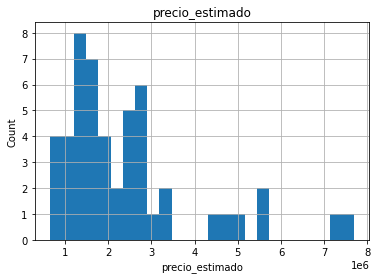

In [69]:
# chequeo
# Distribucion del target
df_oot_final_sample['precio_estimado'].hist(bins=25)
plt.xlabel('precio_estimado')
plt.ylabel("Count")
plt.title('precio_estimado')
plt.show()

In [71]:
df_oot_final_sample.shape

(50, 13)

In [74]:
# Guardamos el rdo final
current_date = datetime.today().strftime('%Y-%m-%d')
df_scoreo_oot_final_sample.to_excel(f'resultados/simulaciones/simulacion_{foco_muestra}_{current_date}.xlsx')
# en esta última linea, poner el path que querramos para guardar el output